<a href="https://colab.research.google.com/github/SUTFutureCoder/BestColabDLCollection/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Neural Network

**Authors:** Yen-Ling Kuo and Eugenio Piasini for the [Brains, Minds and Machines summer course 2018](http://cbmm.mit.edu/summer-school/2018).

At this point, we have seen how to implement various feed-forward networks. In this tutorial, we will learn how to build recurrent networks that maintain the states while processing sequences.

In [0]:
!pip3 install torch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

### Simple RNN to Learn Sine Wave

First, we are going to build a simple RNN that can reproduce the sine wave we provide for training.

The input tensor to a RNN has size (sequence_length, batch_size, input_size). We will need to turn our input data to the same size using [view(.)](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view).

*   `sequence_length` is the length of the sine wave. Here, we put -1 to match any length if other dimensions have fixed size.
*   `batch_size` is the number of sequences we are going to train together. Since we only have one input sine wave, we have an 1 here.
*  `input_size` is the number of features at each time step. For sine wave, we have one x value a time, thus, an 1 here.



In [9]:
num_time_steps = 10

time_steps = np.linspace(0, 2*np.pi, num_time_steps)
data = np.sin(time_steps)
xs = data[:-1]
ys = data[1:]
print(data[:-1])

train_x = torch.Tensor(xs).view(-1, 1, 1)
train_y = torch.Tensor(ys)

[ 0.          0.64278761  0.98480775  0.8660254   0.34202014 -0.34202014
 -0.8660254  -0.98480775 -0.64278761]
tensor([[[ 0.0000]],

        [[ 0.6428]],

        [[ 0.9848]],

        [[ 0.8660]],

        [[ 0.3420]],

        [[-0.3420]],

        [[-0.8660]],

        [[-0.9848]],

        [[-0.6428]]])


The simplest RNN we can build consists of a RNN cell and a fully connected layer to readout the output value from the hidden states.

In the forward method, we unroll the the recurrent computation for each time step in the for loop.

In addition to the predicted output values, the forward method also returns a vector for the hidden state so we can continue building a sequence based on the hidden state from previous time step.

In [0]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1,
                          hidden_size=hidden_size,
                          num_layers=1)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, seq, hc=None):
        tmp, hc = self.rnn(seq, hc)
        out = self.linear(tmp)
        return out, hc

We can set the hyperparameters and run training as before. Again, we use mean squared error to compute the loss for the real values.

In [0]:
hidden_size = 16
learning_rate = 0.01

model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [12]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.41650545597076416
Epoch 10: loss 0.007402567192912102
Epoch 20: loss 0.01967959851026535
Epoch 30: loss 0.0025746673345565796
Epoch 40: loss 0.002394310664385557
Epoch 50: loss 0.0005844995030201972
Epoch 60: loss 0.00037750767660327256
Epoch 70: loss 8.044004061957821e-05
Epoch 80: loss 5.819283614982851e-05
Epoch 90: loss 3.746922448044643e-05


To re-generate the sine wave, we need to provide the x values to the network. A tensor for the hidden state is maintained over the course of the prediction. Initially, it is None, which means the RNN will initialize the vector to all zeros.

tensor([[0.]])
tensor([[0.6428]])
tensor([[0.9848]])
tensor([[0.8660]])
tensor([[0.3420]])
tensor([[-0.3420]])
tensor([[-0.8660]])
tensor([[-0.9848]])
tensor([[-0.6428]])


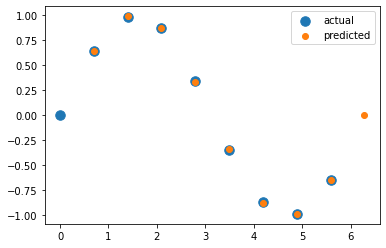

In [19]:
predictions = []
input = train_x[0, :, :]  # choose the first time step as input
hidden_prev = None
for i in range(train_x.shape[0]):
    input = train_x[i, :, :]
    print(train_x[i])
    input = input.view(1, 1, 1)
    pred, hidden_prev = model(input, hidden_prev)
    predictions.append(pred.data.numpy()[0])

x = train_x.data.numpy()
fig, ax = plt.subplots()
plt.scatter(time_steps[:-1], x, s=90, label='actual')
plt.scatter(time_steps[1:], predictions, label='predicted')
ax.legend()

The predicted values seem pretty well-aligned with the training sequence. You can try to give it a different input value to see how robust it is to different initial values.

### LSTM for POS Tagging

In [the lecture](https://drive.google.com/open?id=1NG9wnv3V80PAayuXn4FYQtC5Ss0cpggUr8nES3a1e_s), we showed the example to get the part of speech tag for each word in a sentence. In this section, we will implement an LSTM-based tagger for this task!

The input data are sentences and their POS tags. We need to map the words to indexes so it is easier to manipulate in tensors.

In [0]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

tag_to_ix = {"DET": 0, "NN": 1, "V": 2}
print(tag_to_ix)

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
{'DET': 0, 'NN': 1, 'V': 2}


The model first represent words using word embeddings. Word embeddings are dense vectors of real numbers, one per word in your vocabulary. [`nn.Embedding`](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding) allows us to build a lookup table to store the embeddings. It is also possible to use pre-trained word embeddings in your model (read example [here](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76)).

Different from the RNNs, LSTMs also mantain a cell state. So, we can find the input and output tuple that contains a tensor for the hidden state and another tensor for the cell state. Both are initialized to all zeros. They have size (num_layers, batch_size, hidden_dim).

*  `num_layers`: We can have multiple LSTMs stacked on top of the others. If not specified, the default is one LSTM.
*  `batch_size`: This is the number of sentences we are going to train together. In this example, we train with one sentence a time.
*  `hidden_dim`: This is the length of vectors for the states. 

Similar to the example in the CNN tutorial, we take softmax of the affine map of the hidden state to output the distribution over the label classes.




In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

We have a function to convert a word to an index so that we can feed it to the input. As before, we use negative log likelihood as loss function.

The dimensions for word embedding and hidden states are quite small. Usually, you need a much larger size for real dataset. 

In [0]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)
  
embedding_dim = 6
hidden_dim = 6

model = LSTMTagger(embedding_dim, hidden_dim, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Following the same steps, we train the LSTM model and check out the predicted tag for each word!

In [0]:
for epoch in range(300):
    for sentence, tags in training_data:
        optimizer.zero_grad()
        model.hidden = model.init_hidden()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    _, predicted = torch.max(tag_scores, 1)
    print(training_data[0][0])
    print(predicted)

epoch 0, loss 1.0691885948181152
epoch 50, loss 0.8439609408378601
epoch 100, loss 0.46415096521377563
epoch 150, loss 0.21308235824108124
epoch 200, loss 0.10027572512626648
epoch 250, loss 0.058674246072769165
['The', 'dog', 'ate', 'the', 'apple']
tensor([0, 1, 2, 0, 1])


### Exercise: Generating Shakespeare

In the example above, we work on the word level classification. However, there are cases we may want to generate character one at a time. For example, deciding which character we want to capitalize or generating reasonable names, etc.

In this exercise, you will need to implement a model similar to what we have before but at character level to generate Shakespeare style texts.

First, let's download the training data!

In [0]:
input_file = 'input.txt'
!if [ ! -f $input_file ]; then wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt; fi



```
# This is formatted as code
```

Instead of input a big file for training, we will pick random chunks from the file as the input training sequences.

In [0]:
!pip3 install unidecode

import random
import unidecode

file = unidecode.unidecode(open('input.txt').read())

def random_chunk(chunk_len=200):
    start_index = random.randint(0, len(file) - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]
  
print(random_chunk())

ps of citizens to speak with him,
His grace not being warn'd thereof before:
My lord, he fears you mean no good to him.

BUCKINGHAM:
Sorry I am my noble cousin should
Suspect me, that I mean no good to


Similar to words, we convert words to integer indexes. Each character now has a unique id.

We also provide a function to produce a random training sequence. The input is the character at time $t$. The target is the expected character to see at $t+1$.

In [0]:
import string

# Turn string into list of longs
def char_tensor(str):
    tensor = torch.zeros(len(str), 1).long()
    for c in range(len(str)):
        tensor[c][0] = string.printable.index(str[c])
    return tensor

print(char_tensor('abcDEF'))

def random_train_data():    
    chunk = random_chunk()
    input = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return input, target

tensor([[10],
        [11],
        [12],
        [39],
        [40],
        [41]])


Now, it's your turn to implement the model!

This model will take as input the character for time step $t$ and is expected to output the character at $t+1$. There are three layers - one embedding layer that encodes the input character into a dense vector, one GRU layer (yes, let's try GRU instead of LSTM this time!) that operates on that dense vector and a hidden state, and a decoder layer that outputs the probability distribution over all possible characters.

You can take a look at the GRU documentation ([`nn.GRU`](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)), the usage is very similar to RNNs and LSTMs.

In [0]:
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(ShakespeareRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # TODO: design your structure

    
    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def forward(self, input, hidden):
        # TODO: complete your forward pass

        return output, hidden

To check out the generation result, we provide you an evaluate function so you can pick any character to start with to generate a paragraph using the trained model.

The generation process works as follows. We will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. 

In [0]:
def evaluate(model, prime_str='A', predict_len=100):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    input = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(input, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        input = char_tensor(predicted_char)

    return predicted

Finally, we define the training parameters, instantiate the model, and start training. 

Please complete the missing training script! Once you start training, you can see how the generated texts evolve every 100 epoch.

In [0]:
n_characters = len(string.printable)
hidden_size = 100
n_layers = 1

epochs = 2000
lr = 0.005

model = ShakespeareRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    loss = 0
    input, target = random_train_data()
    chunk_len = len(input)
    
    # TODO: complete the training script


    loss = loss.item() / chunk_len
    if epoch % 100 == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

[(0 0%) 4.6329]
z
Mh`!?^&g;!xX2	?H^oU0z$3yk$8K7D<[m 6y8zff#8n~QPRXy $QT`+;	&7yA_MTo7].v:+# 

[(100 5%) 2.3615]
Whak! maft; weeku
An's girsg
Ho wo I I or
Silay.
LARGpeante
 of.

As:
Whour derou, lave to thiI sit co 

[(200 10%) 2.2515]
Whtoble mach Banke; Wesoulle:
The coothe un it.

PRERme his hast as by Eeind rour, lows yas

Cllllist
 

[(300 15%) 2.2235]
Wh'd paich a dughseirseel deere that;
Chave plizeld my wiche forne| hear;
Mut an ame gondagseare; his! 

[(400 20%) 2.0030]
Whpanting let the loved.
'Tid would a what grangengs;, will the wrerede ford vill not wold,
Misn linef 

[(500 25%) 1.8342]
Whe hik will wire I will Kik.

SAYFBY BARD:
Celver my ginligan of the that thee's ner.

RIORNUCES:
I r 

[(600 30%) 1.8704]
Whough and likgher mant.

SSA:
Ding seesp ling of a dots of tell; this go himbye,
Theres:
The kissh Mu 

[(700 35%) 1.9027]
Whe, you welp gomgh, his, that: I baily,
Mer thaup'ld bonous may know ank weuld surfo?

DUCIUS:
Ma so  

[(800 40%) 2.0641]
Whe carster my goos

### Congrats! 

You have finished the whole tutorial series.

Feel free to explore different models with the tools you just learned and let us know if you have any question!